In [553]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pd_support import read_df_csv
import scipy
from scipy.spatial.transform import Rotation as R

In [554]:
cart_df = pd.read_csv("..//straight_line_sideways.csv")

In [555]:
cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-15 12:13:22.489984,13,-5,7,3
1,2022-06-15 12:13:37.124103,20,1,14,10
2,2022-06-15 12:13:37.124103,20,1,14,10
3,2022-06-15 12:13:37.124604,20,1,14,10
4,2022-06-15 12:13:37.124604,20,1,14,10
...,...,...,...,...,...
3529,2022-06-15 12:14:09.344631,-7439,8332,8437,-8135
3530,2022-06-15 12:14:09.345196,-7439,8332,8437,-8135
3531,2022-06-15 12:14:09.345196,-7439,8332,8437,-8135
3532,2022-06-15 12:14:09.345196,-7439,8332,8437,-8135


In [556]:
mc, mc_dt = read_df_csv("..//cart_linear_sideways_mc.csv")
mc_dt

datetime.datetime(2022, 6, 15, 12, 13, 29, 772000)

In [557]:
type(mc["center_y"][0])

numpy.float64

In [558]:
mc = mc.rename(columns={"time":"seconds"})

In [559]:
_t = []
for i in list(mc["seconds"]):
    _t.append(mc_dt + timedelta(0,float(i)))

mc["time"] = _t

In [560]:
mc

,frame,seconds,center_x,center_y,center_z,org_x,org_y,org_z,xdir_x,xdir_y,xdir_z,zdir_x,zdir_y,zdir_z,time
0,0,0.00,0.376711,0.061965,0.048003,0.336798,0.061981,-0.017959,0.416365,0.060203,-0.015434,0.334189,0.063507,0.109515,2022-06-15 12:13:29.772
1,1,0.01,0.376718,0.061963,0.048005,0.336790,0.061988,-0.017958,0.416369,0.060193,-0.015421,0.334194,0.063522,0.109507,2022-06-15 12:13:29.782
2,2,0.02,0.376716,0.061963,0.048015,0.336800,0.062010,-0.017967,0.416390,0.060189,-0.015428,0.334197,0.063521,0.109513,2022-06-15 12:13:29.792
3,3,0.03,0.376717,0.061982,0.048010,0.336802,0.061984,-0.017958,0.416364,0.060215,-0.015432,0.334195,0.063524,0.109503,2022-06-15 12:13:29.802
4,4,0.04,0.376725,0.061983,0.048010,0.336806,0.062019,-0.017969,0.416386,0.060197,-0.015427,0.334199,0.063509,0.109510,2022-06-15 12:13:29.812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3771,3771,37.71,-0.259718,0.074456,0.032517,-0.295468,0.075046,-0.035858,-0.216485,0.072623,-0.028880,-0.305695,0.075331,0.091150,2022-06-15 12:14:07.482
3772,3772,37.72,-0.259718,0.074461,0.032516,-0.295468,0.075018,-0.035852,-0.216473,0.072621,-0.028879,-0.305703,0.075329,0.091161,2022-06-15 12:14:07.492
3773,3773,37.73,-0.259725,0.074467,0.032514,-0.295458,0.075047,-0.035849,-0.216485,0.072634,-0.028877,-0.305710,0.075306,0.091175,2022-06-15 12:14:07.502
3774,3774,37.74,-0.259725,0.074449,0.032517,-0.295471,0.075023,-0.035861,-0.216482,0.072616,-0.028889,-0.305722,0.075303,0.091165,2022-06-15 12:14:07.512


In [561]:
mc["time"] = pd.to_datetime(mc["time"])

In [562]:
"""getting initial values of motion capture data"""

marker_cen = np.array(mc[["center_x", "center_y", "center_z"]].iloc[0]).T
marker_xvec = np.array(mc[["xdir_x", "xdir_y", "xdir_z"]].iloc[0]).T
marker_zvec = np.array(mc[["zdir_x", "zdir_y", "zdir_z"]].iloc[0]).T
marker_org = np.array(mc[["org_x", "org_y", "org_z"]].iloc[0]).T
marker_org[0]

0.336798

In [563]:
v1 = marker_xvec - marker_org #v1
v2 = marker_zvec - marker_org #v2

v1 = v1.reshape(3,1)
v2 = v2.reshape(3,1)
v3 = marker_org.reshape(3,1)

In [564]:
def calculate_rotmat(xdir,zdir,org):
    """
    this function calculates rotation matrix
    """
    v1 = xdir - org #v1
    v2 = zdir - org #v2

    vxnorm = v1/np.linalg.norm(v1)

    vzcap = v2 - (vxnorm.T @ v2) * vxnorm
    vznorm = vzcap/ np.linalg.norm(vzcap)

    vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3,1)
    rotMat = np.hstack((vxnorm, vynorm, vznorm))
    return rotMat

In [565]:
"""getting initial rot mat in mc data"""

rot_mat = calculate_rotmat(v1, v2, v3)
rot_mat

array([[-0.96774126,  0.25042626,  0.02763225],
       [-0.23987084, -0.94934797,  0.20297885],
       [ 0.07706385,  0.18980284,  0.97879316]])

In [566]:
temp_list = []
for i in range(len(mc["xdir_x"])):
    center_val =  np.array(mc[["center_x", "center_y", "center_z"]].iloc[i])
    center_val = center_val.reshape(3,1)
    transformed_center = rot_mat.T @ center_val + marker_cen
    transformed_center = transformed_center.T[0]
    temp_list.append(transformed_center)
mc[["cen_x", "cen_y", "cen_z"]] = temp_list

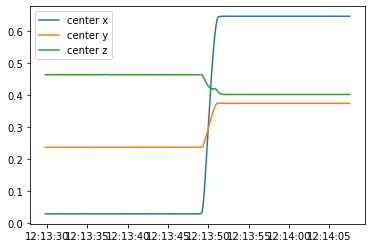

In [567]:
plt.plot(mc["time"], mc["cen_x"], label="center x")
plt.plot(mc["time"], mc["cen_y"], label="center y")
plt.plot(mc["time"], mc["cen_z"], label="center z")
plt.legend()

In [568]:
"""resetting cart values to zero"""
cart_df["e_fr"] = cart_df["e_fr"]- cart_df["e_fr"].iloc[0]
cart_df["e_fl"] = cart_df["e_fl"]- cart_df["e_fl"].iloc[0]
cart_df["e_rr"] = cart_df["e_rr"]- cart_df["e_rr"].iloc[0]
cart_df["e_rl"] = cart_df["e_rl"]- cart_df["e_rl"].iloc[0]

cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-15 12:13:22.489984,0,0,0,0
1,2022-06-15 12:13:37.124103,7,6,7,7
2,2022-06-15 12:13:37.124103,7,6,7,7
3,2022-06-15 12:13:37.124604,7,6,7,7
4,2022-06-15 12:13:37.124604,7,6,7,7
...,...,...,...,...,...
3529,2022-06-15 12:14:09.344631,-7452,8337,8430,-8138
3530,2022-06-15 12:14:09.345196,-7452,8337,8430,-8138
3531,2022-06-15 12:14:09.345196,-7452,8337,8430,-8138
3532,2022-06-15 12:14:09.345196,-7452,8337,8430,-8138


In [569]:
mils = np.arange(0, len(cart_df["e_fr"])*10, 10)
cart_df["mils"] = mils
cart_df["sys_time"] = pd.to_datetime(cart_df["sys_time"])

These are the parameters of the cart

Diameter = 95 mm
radius = 47.5
wheel thickness = 45 mm
gap between wheel and chassis = 6.5 mm
angle between center of chassis and z-dir vector = 51.21 degrees
distance between the wheel = 158 mm
distance between the wheel and the center of the robot = 101.36 (li)


In [570]:
"""circumfrence of the wheel"""

cir_wheel = np.degrees(2*np.pi*(47.5/1000))
cir_wheel
radius = 47.5/1000

lx = 79 #half of the distance between the wheels
ly = 122.5/2

lx = lx/1000
ly = ly/1000

The encoder values will give 4000 values per revolution
360/4000 = 0.09 degrees per encoder rotation value

In [571]:
""" angular velocity"""
cart_df["av_fr"] = (cart_df["e_fr"]*0.09).diff()/0.01
cart_df["av_fl"] = (cart_df["e_fl"]*0.09).diff()/0.01
cart_df["av_rr"] = (cart_df["e_rr"]*0.09).diff()/0.01
cart_df["av_rl"] = (cart_df["e_rl"]*0.09).diff()/0.01
cart_df['av_fr'] = cart_df["av_fr"].fillna(0)
cart_df['av_fl'] = cart_df["av_fl"].fillna(0)
cart_df['av_rr'] = cart_df["av_rr"].fillna(0)
cart_df['av_rl'] = cart_df["av_rl"].fillna(0)

#converting them to radians
cart_df['av_fr'] = cart_df["av_fr"]* np.pi/180
cart_df['av_fl'] = cart_df["av_fl"]* np.pi/180
cart_df['av_rr'] = cart_df["av_rr"]* np.pi/180
cart_df['av_rl'] = cart_df["av_rl"]* np.pi/180

cart_df["av_fl"]

0       0.000000
1       0.942478
2       0.000000
3       0.000000
4       0.000000
          ...   
3529    0.000000
3530    0.000000
3531    0.000000
3532    0.000000
3533    0.000000
Name: av_fl, Length: 3534, dtype: float64

In [572]:
# g1 = np.radians(-51.21)
# g2 = np.radians(51.21)

g1 = np.radians(-np.pi/2)
g2 = np.radians(np.pi/2)

g3 = g2
g4 = g1


b1 = np.pi/4
b2 = -np.pi/4
b3 = b1
b4 = b2


a1 = np.pi/4
a2 = -np.pi/4
a3 = 3*np.pi/4
a4 = -3*np.pi/4


li = 101.36/1000

In [573]:
t = (-1/radius)*np.array([[np.cos(b1 - g1)/ np.sin(g1), np.sin(b1 - g1)/np.sin(g1), li * np.sin(b1 - g1 - a1)/np.sin(g1)],
                         [np.cos(b2 - g2)/ np.sin(g2), np.sin(b2 - g2)/np.sin(g2), li * np.sin(b2 - g2 - a2)/np.sin(g2)],
                         [np.cos(b3 - g3)/ np.sin(g3), np.sin(b3 - g3)/np.sin(g3), li * np.sin(b3 - g3 - a3)/np.sin(g3)],
                         [np.cos(b4 - g4)/ np.sin(g4), np.sin(b4 - g4)/np.sin(g4), li * np.sin(b4 - g4 - a4)/np.sin(g4)]]
                         )
t
pseudo_t = np.linalg.pinv(t)
pseudo_t

array([[ 4.47561242e-04, -4.47561242e-04, -4.72799786e-04,
         4.72799786e-04],
       [ 8.73787444e-04,  8.73787444e-04, -2.39613824e-05,
        -2.39613824e-05],
       [ 5.92854944e-03,  5.92854944e-03,  6.26286783e-03,
         6.26286783e-03]])

In [574]:
val = pseudo_t @ np.array([[cart_df["av_fr"][0]],[cart_df["av_fl"][0]], [cart_df["av_rr"][0]], [cart_df["av_rl"][0]]])
val.T

array([[0., 0., 0.]])

In [575]:
np.array([[cart_df["av_fr"][0]],[cart_df["av_fl"][0]], [cart_df["av_rr"][0]], [cart_df["av_rl"][0]]])

array([[0.],
       [0.],
       [0.],
       [0.]])

In [576]:
_val = []
for i in range(len(cart_df["e_fl"])):
    _v = pseudo_t @ np.array([[cart_df["av_fr"][i]],[cart_df["av_fl"][i]], [cart_df["av_rr"][i]], [cart_df["av_rl"][i]]])
    _val.append(_v.T[0])

cart_df[["cal_vx", "cal_vy", "cal_w"]] = _val
# _val

In [577]:
"""finding vx, vy, w"""

cart_df["vx"] = (cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] + cart_df["av_rr"])*(radius/4)
cart_df["vy"] = (- cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] - cart_df["av_rr"])*(radius/4)
cart_df["w"] = (- cart_df["av_fl"] + cart_df["av_fr"] - cart_df["av_rl"] + cart_df["av_rr"])*(radius/(4*(lx + ly)))

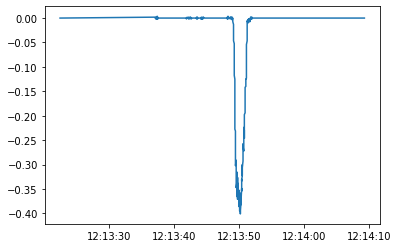

In [578]:
plt.plot(cart_df["sys_time"], cart_df["vy"])
# plt.plot(cart_df["vx"])

In [579]:
"""calculating displacement
s=(1/2)* (v+u)t
v = current velocityn
u = initial velocity
t = time
s = displacement
"""

_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["vx"].iloc[i] + cart_df["vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["vy"].iloc[i] + cart_df["vy"].iloc[i-1])*0.01
        print(y_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+y_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["x_val"] = _xval
cart_df["y_val"] = _yval
# cart_df["y_val"]

9.326603190344698e-06
9.326603190344698e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.326603190344695e-06
9.326603190344695e-06
-9.326603190344695e-06
-9.326603190344695e-06
0.0
0.0
0.0
9.326603190344695e-06
9.326603190344695e-06
0.0
0.0
0.0
0.0
0.0
0.0
-9.326603190344695e-06
-9.326603190344695e-06
0.0
9.326603190344695e-06
0.0
-9.326603190344695e-06
9.326603190344705e-06
9.326603190344705e-06
0.0
0.0
-9.887923813067802e-21
-9.326603190344705e-06
9.326603190344701e-06
1.8653206380689396e-05
-9.326603190344698e-06
5.4210108624275225e-21
9.326603190344701e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [580]:
"""calculating displacement for calculated coordinates

"""
_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["cal_vx"].iloc[i] + cart_df["cal_vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["cal_vy"].iloc[i] + cart_df["cal_vy"].iloc[i-1])*0.01
        # print(x_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+y_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["cal_x"] = _xval
cart_df["cal_y"] = _yval


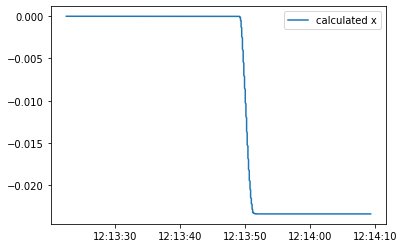

In [581]:
# plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "ideal x")
plt.plot(cart_df["sys_time"],cart_df["cal_x"], label = "calculated x")
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "idal x")
plt.legend()

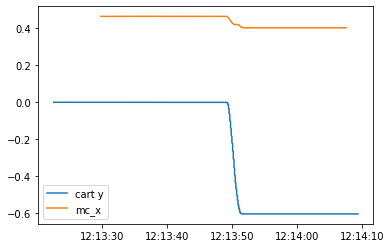

In [590]:
plt.plot(cart_df["sys_time"], cart_df["y_val"], label = "cart y")
plt.plot(mc["time"], mc["cen_z"], label  = "mc_x")
plt.legend()

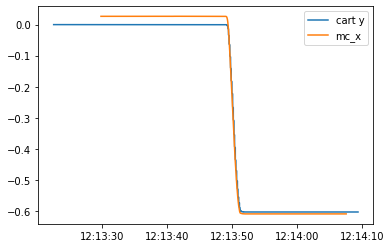

In [583]:
plt.plot(cart_df["sys_time"], cart_df["y_val"], label = "cart y")
plt.plot(mc["time"], mc["center_x"] -0.35, label  = "mc_x")

plt.legend()

In [584]:
rw = []
vr = []
for i in range(len(cart_df["av_rl"])):
    _vy = cart_df["cal_vy"][i]
    _vx = cart_df["cal_vx"][i]
    rw.append(np.arctan2(_vy, _vx))
    vr.append(np.linalg.norm((_vx, _vy)))
cart_df["rw"] = rw
cart_df["vr"] = vr

In [585]:
cart_df["rw"]

0       0.000000
1       1.530219
2       0.000000
3       0.000000
4       0.000000
          ...   
3529    0.000000
3530    0.000000
3531    0.000000
3532    0.000000
3533    0.000000
Name: rw, Length: 3534, dtype: float64

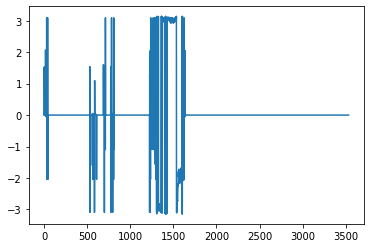

In [586]:
plt.plot(cart_df["rw"])

In [587]:
cart_df["rw"]

0       0.000000
1       1.530219
2       0.000000
3       0.000000
4       0.000000
          ...   
3529    0.000000
3530    0.000000
3531    0.000000
3532    0.000000
3533    0.000000
Name: rw, Length: 3534, dtype: float64